# Lesson 05 Assignment - Hypothesis Simulation 

## Author - Rodolfo Lerma

# Abstract

This analysis is divided in the following way:

### Data Cleaning:

### Analysis:

- **Functions for analysis:**


- **1) Likely distribution for price**
  - Boostraping (`Fuel-Type`)
  - Bayes Model (`Fuel-Type`)


- **2) Basic Summary Statistics by Boostrap & Bayesian**
  - Boostraping (`Fuel-Type`)
  - Bayes Model (`Fuel-Type`)


- **3) Confidence intervals of Summary Stats by Boostrap & Bayesian**
  - Classic Model (`Fuel-Type`)
  - Boostraping (`Fuel-Type`)
  - Bayes Model (`Fuel-Type`)


- **4) Hypothesis Test (compare t-test, Tukey HSD, ANOVA Vs results from Bootstraping and Bayesian Model)**
  - Classic Model (`Fuel-Type`)
  - Boostraping (`Fuel-Type`)
  - Bayes Model (`Fuel-Type`)

# Data cleaning

In [1]:
#Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as ss
import seaborn as sns
from sklearn.preprocessing import scale
from scipy.stats import kstest
from scipy import stats
import statsmodels.stats.weightstats as ws    
from statistics import mean
import statsmodels.stats.power as ssp
import itertools
import scipy
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"
#fileName = "Automobile_price.csv"

In [3]:
auto = pd.read_csv(fileName)

In [4]:
#added_columns = ["normalized-losses","symboling"]
used_columns = ["fuel-type","aspiration","drive-wheels","body-style","price"]
for i in used_columns:
    auto.loc[auto[i] == '?', i] = np.nan
auto[used_columns].isnull().sum()

fuel-type       0
aspiration      0
drive-wheels    0
body-style      0
price           4
dtype: int64

In [5]:
#Once the data is clean the variable "price_log" is created.
auto.dropna(axis = 0, inplace = True)

#Column price from str to numeric (int64)
auto['price'] = pd.to_numeric(auto['price'])

#Creating a variable called `price_log`
auto['price_log'] = np.log(auto['price'])

# Analysis

## Functions for anaysis

In [6]:
def qq_plot(vec1, vec2):
    plt.figure(figsize=(12, 12)).gca() # define axis
    ax1 = plt.subplot(221) ## setup the left subplot
    ss.probplot(vec1, plot = ax1) ## Plot the left subplot
    ax1 = plt.subplot(222) ## Set up the right subplot
    ss.probplot(vec2, plot = ax1) ## Plot the right subplot
    
def plot_cums(dist1, dist2):
    ## sort the first data sample:
    data_sorted = np.sort(dist1)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(dist1)) / (len(dist1) - 1)
    # Now plot as line and scatter plot. 
    plt.plot(data_sorted, p, color = 'blue')
    plt.scatter(data_sorted, p, color = 'red')
    # sort the seond data sample:
    data_sorted = np.sort(dist2)
    # And the second plot
    plt.plot(data_sorted, p, color = 'orange')
    plt.scatter(data_sorted, p, color = 'green')

def ks_test(dat, dist = 'norm'):
    ks_statisic, pvalue = kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))

def t_test(a, b, alpha, alternative='two-sided'):
    diff = a.mean() - b.mean()
    res = ss.ttest_ind(a, b, equal_var=False)  
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()
    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)

def plot_dists(a, b, nbins, a_label='pop_A', b_label='pop_B'):
    # Create a single sequence of bins to be shared across both
    # distribution plots for visualization consistency.
    combined = pd.concat([a, b])
    breaks = np.linspace(
        combined.min(), 
        combined.max(), 
        num=nbins+1)
    plt.subplot(2, 1, 1)
    plt.hist(a,  bins=breaks, label=a_label, alpha=0.5)
    plt.axvline(a.mean(), linewidth=4)
    plt.legend() 
    plt.title(a_label) 
    plt.subplot(2, 1, 2)
    plt.hist(b,  bins=breaks, label=b_label, alpha=0.5)
    plt.axvline(b.mean(), linewidth=4)
    plt.legend() 
    plt.title(b_label) 
    plt.tight_layout()
    
#Kernel Density Estimation Plots (to take a look at the Distribution for each of the variables)
def kde_plot(a,b,c,d,e):
    fig = plt.figure(figsize=(6,4)) # Define plot area
    ax = fig.gca() # Define axis 
    sns.set_style("whitegrid")
    sns.kdeplot(a, ax = ax, label = c)
    sns.kdeplot(b, ax = ax, label = d)
    ax.set_title('KDE plot of auto price ' + e, fontsize = 15) # Give the plot a main title
    ax.set_xlabel('Price', fontsize = 15) # Set text for the x axis
    ax.set_ylabel('Density', fontsize = 15)# Set text for y axis
    ax.legend(loc='upper right', fontsize=15)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.grid(True)    
    
def plot_hist(x, p=5):
    # Plot the distribution and mark the mean
    plt.hist(x, alpha=.5)
    plt.axvline(x.mean())
    plt.axvline(np.percentile(x, 100-p/2.), color='red', linewidth=3)
    # 95% confidence interval    
    plt.axvline(np.percentile(x, p/2.), color='red', linewidth=3)

def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity

def comp_like(p, x): 
    variance = np.std(x)**2 # sigmasqr
    x_mean = np.asarray(x).mean()  # xbar
    print('Mean = %.3f, Standard deviation = %.3f' % (x_mean, np.std(x)))
    n = len(x)
    l = np.exp(-n * np.square(x_mean - p) / (2 * variance))
    return l / l.sum()

def plot_ci(p, post, num_samples, lower_q, upper_q):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size=num_samples, replace=True, p=post)
    ci = scipy.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles. Assumes a pretty symmetrial distribution
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval, fontsize = 15)
    plt.plot(p, post, color='blue')
    plt.xlabel('Parameter value', fontsize = 15)
    plt.ylabel('Density', fontsize = 15)
    plt.xlim(9, 10)
    plt.axvline(x=ci[0], color='red')
    plt.axvline(x=ci[1], color='red')
    print('The %.3f credible interval is %.3f to %.3f' 
          % (interval, ci[0], ci[1]))

def kde_plots(a,b,c,d,e,f,g):
    fig = plt.figure(figsize=(10,8)) # Define plot area
    ax = fig.gca() # Define axis 
    sns.set_style("whitegrid")
    sns.kdeplot(a, ax = ax, label = d)
    sns.kdeplot(b, ax = ax, label = e)
    sns.kdeplot(c, ax = ax, label = f)
    ax.set_title('KDE plot of auto price ' + g, fontsize = 20) # Give the plot a main title
    ax.set_xlabel('Price', fontsize = 15) # Set text for the x axis
    ax.set_ylabel('Density', fontsize = 15)# Set text for y axis
    ax.legend(loc='upper right', fontsize=15)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.grid(True)

## 1) Likely distribution for price

In [7]:
#Normalizing each of the price variables so it is possible to see both with same X axis and compare shapes
norm1_s = scale(auto['price'])
norm2_s = scale(auto['price_log'])

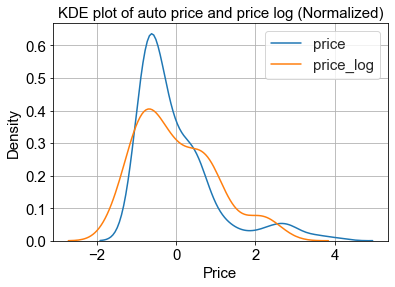

In [8]:
kde_plot(norm1_s,norm2_s,"price","price_log","and price log (Normalized)")

It is possible to see that most of the extreme features seen in the `price` variable are minimized by using the `price_log` variable. Which seems to be closer to a **Normal Distribution**.

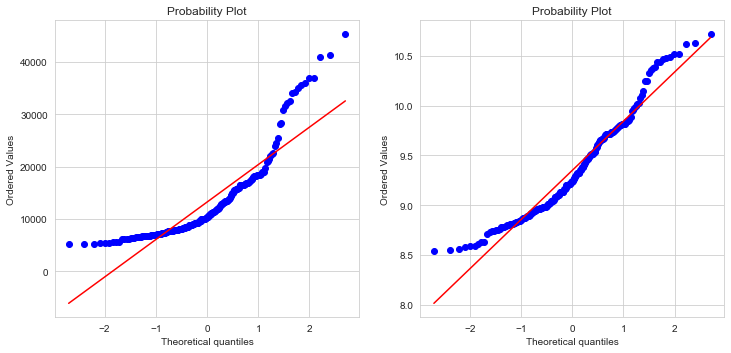

In [9]:
qq_plot(auto['price'], auto['price_log'])  

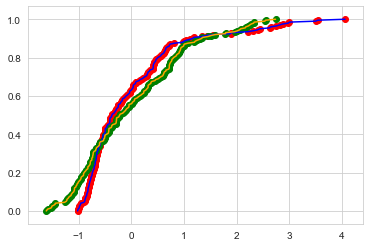

In [10]:
plot_cums(norm1_s, norm2_s) 

In [11]:
ks_test(norm1_s)

KS-statistic = 0.1542761480184771
P-value = 0.00012108611006800808


In [12]:
ks_test(norm2_s)

KS-statistic = 0.09781904713791056
P-value = 0.03984598613097214


Based on the previous analysis it seems that `price_log` gets closer to a Normal distribution compared to `price` and for that reason that variable is the one that will be used throughout this assignment.

## 2) Basic Summary Statistics by Boostrap & Bayesian 

For this section of the analysis and for simplicity just one column (variable) will be used: `fuel-type` this to provide an easy to follow story line for the comparison between **Boostrap** and **Bayesian models**.

### Boostraping (`Fuel-Type`)

In [13]:
auto['fuel-type'].unique()

array(['gas', 'diesel'], dtype=object)

In [14]:
#Splitting the data into the 2 categories inside the chosen variable
gas = auto[auto['fuel-type'] == 'gas']
diesel = auto[auto['fuel-type'] == 'diesel']

#Size of each variable
len(gas),len(diesel)

(181, 20)

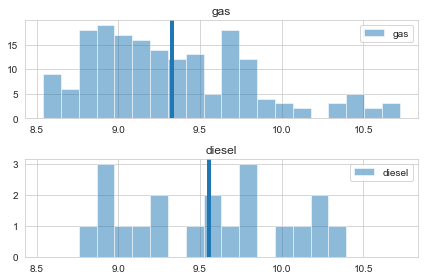

In [15]:
plot_dists(gas['price_log'], diesel['price_log'], 20, a_label='gas', b_label='diesel')

Plotting the original data is hard to tell if there is any statistical significant difference between the 2 samples (gas/diesel). But in the section below boostraping the mean for both samples will shed some light into this.

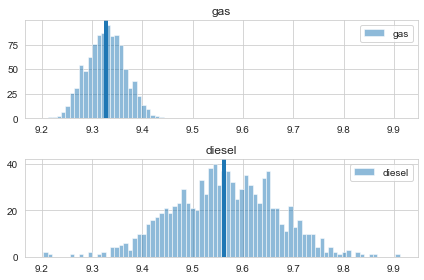

In [16]:
#Boostraping the mean for each of the 2 samples (Gas Vs Diesel)
n_replicas = 1000

gas_bootstrap_means = pd.Series([
    gas.sample(frac=1, replace=True).price_log.mean()
    for i in range(n_replicas)])

diesel_bootstrap_means = pd.Series([
        diesel.sample(frac=1, replace=True).price_log.mean()
        for i in range(n_replicas)])

plot_dists(gas_bootstrap_means, diesel_bootstrap_means, 
           nbins=80, a_label='gas', b_label='diesel')

summary_gas = gas_bootstrap_means.describe()
summary_diesel = diesel_bootstrap_means.describe()

It is possible to see a difference 2 samples after boostraping the mean.

0     -0.383623
1     -0.397971
2     -0.330192
3     -0.331120
4     -0.329967
5     -0.146566
6     -0.225221
7     -0.242264
8     -0.192761
9     -0.393122
10    -0.228237
11    -0.012886
12    -0.274566
13    -0.287954
14    -0.103837
15    -0.156628
16    -0.320415
17    -0.147016
18    -0.295497
19    -0.305311
20    -0.416109
21    -0.352333
22    -0.288471
23    -0.123817
24    -0.078247
25    -0.175634
26    -0.313169
27    -0.121533
28    -0.257464
29    -0.187447
         ...   
970   -0.221485
971   -0.033596
972   -0.215980
973   -0.191923
974   -0.453391
975   -0.239283
976   -0.115156
977   -0.222386
978   -0.395453
979   -0.214978
980   -0.299081
981   -0.211241
982   -0.416093
983   -0.324898
984   -0.361354
985   -0.234661
986   -0.262244
987   -0.239295
988   -0.099279
989   -0.202837
990   -0.442113
991   -0.210525
992   -0.190408
993   -0.288989
994   -0.194786
995    0.016897
996   -0.270934
997   -0.222752
998   -0.120493
999   -0.267177
Length: 1000, dtype: flo

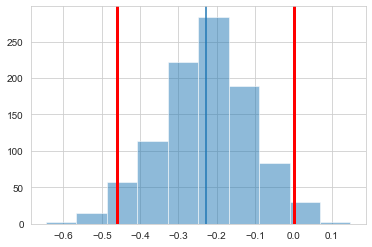

In [38]:
diffs = []
for i in range(n_replicas):
    sample = auto.sample(frac=1.0, replace=True)
    gas_sample_mean = sample[sample['fuel-type'] == 'gas'].price_log.mean()
    diesel_sample_mean = sample[sample['fuel-type'] == 'diesel'].price_log.mean()
    diffs.append(gas_sample_mean - diesel_sample_mean)
diffs = pd.Series(diffs)

plot_hist(diffs)

The differences in mean between the `gas` & `diesel` after boostraping seems to be around 0.2 in average.

The summary statistics for this couple of variables (`gas` & `diesel`) after boostraping:

In [18]:
print('Gas Boostrap')
print(summary_gas)
print('******************')
print('Diesel Boostrap')
print(summary_diesel)

Gas Boostrap
count    1000.000000
mean        9.327098
std         0.037313
min         9.213537
25%         9.300991
50%         9.327545
75%         9.352709
max         9.434901
dtype: float64
******************
Diesel Boostrap
count    1000.000000
mean        9.563017
std         0.102749
min         9.202611
25%         9.489658
50%         9.563711
75%         9.637057
max         9.911892
dtype: float64


### Bayes Model (`Fuel-Type`)

Mean = 9.327, Standard deviation = 0.498


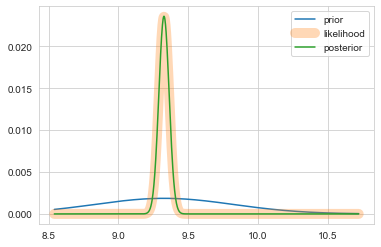

In [19]:
N = 1000
p = np.linspace(min(auto.price_log),max(auto.price_log), num=N)

pp_gas = scipy.stats.norm.pdf(p, loc=gas.price_log.mean(), scale= np.std(gas.price_log))
pp_gas = pp_gas / pp_gas.sum() # normalize

like_gas = comp_like(p, gas.price_log)
post_gas = posterior(pp_gas, like_gas)

plt.plot(p, pp_gas, label='prior')
plt.plot(p, like_gas, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p, post_gas, label='posterior')
plt.legend()

Mean = 9.557, Standard deviation = 0.476


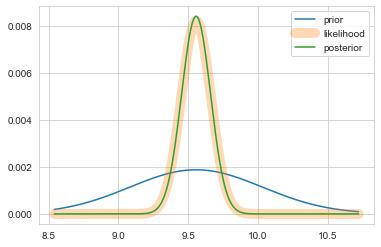

In [20]:
pp_diesel = scipy.stats.norm.pdf(p, loc=diesel.price_log.mean(), scale= np.std(diesel.price_log))
pp_diesel = pp_diesel / pp_diesel.sum() # normalize

like_diesel = comp_like(p, diesel.price_log)
post_diesel = posterior(pp_diesel, like_diesel)

plt.plot(p, pp_diesel, label='prior')
plt.plot(p, like_diesel, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p, post_diesel, label='posterior')
plt.legend()

## 3) Confidence intervals of Summary Stats by Boostrap & Bayesian

### Classic Model (`Fuel-Type`)

In [21]:
previous_gas = gas["price_log"]
previous_diesel = diesel["price_log"]
test = t_test(previous_gas, previous_diesel, 0.05)
test

DegFreedom    23.626756
Difference    -0.230212
Statistic     -1.997083
PValue         0.057460
Low95CI       -0.468326
High95CI       0.007901
dtype: float64

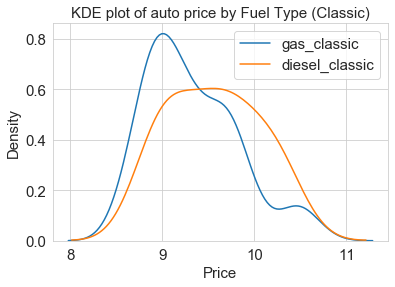

In [22]:
kde_plot(previous_gas,previous_diesel,"gas_classic","diesel_classic","by Fuel Type (Classic)")

### Boostrap (`Fuel-Type`)

In [23]:
test = t_test(gas_bootstrap_means, diesel_bootstrap_means, 0.05)
test

DegFreedom    1257.976942
Difference      -0.235919
Statistic      -68.247305
PValue           0.000000
Low95CI         -0.242701
High95CI        -0.229137
dtype: float64

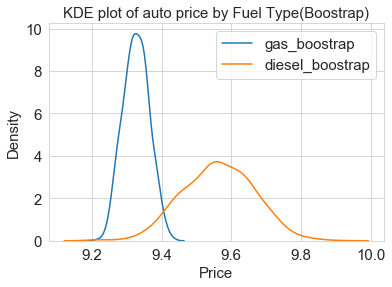

In [24]:
kde_plot(gas_bootstrap_means,diesel_bootstrap_means,"gas_boostrap","diesel_boostrap","by Fuel Type(Boostrap)")

The T-test over the boostraped variable is giving Zero value, meaning that after boostraping 1000 times the two distributions are statistically different.

### Bayes Model (`Fuel-Type`)

In [25]:
num_samples = 100000
lower_q, upper_q = [.025, .975]

The 0.950 credible interval is 9.255 to 9.399
The 0.950 credible interval is 9.353 to 9.760


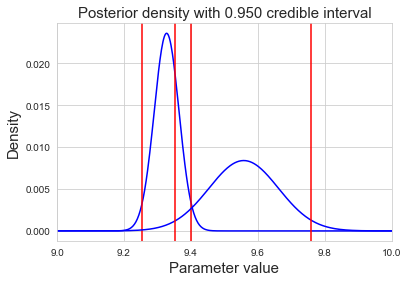

In [26]:
plot_ci(p, post_gas, num_samples, lower_q=.025, upper_q=.975)
plot_ci(p, post_diesel, num_samples, lower_q=.025, upper_q=.975)

There a small overlapping for the 95% Credible interval of 0.046. It could be argued both ways: Since there is overlapping we can determine that there is no statisticall difference between both distributions, which what we saw from the classic approach T-Test results. Or since the overlapping is so minimal then it could be argued that there is a difference between the 2 variables. Since we have evidence from the boostrap method that there is difference, the results in here would be interpreted as enough to determine a difference between the 2 samples.

**Notice the shape for both distributions (Boostraping and Bayes) are pretty similar.**

### Summary of this section

Based on the above results it is possible to compare the 3 analysis, **Classic** (with original data), **Bootrap** & **Bayes**.

- The T-Test for the original data set tells us (strictly speaking) that there is no difference between both populations, but the value is so close to the cutoff value that practically speaking we could accept the alternative.

- The T-Test done on the Boostraped sample tells us that after further consideration there is in fact a difference in the 2 samples.

- And finally the Bayes Model aligns with the Boostrap method, telling us that there is a difference between both samples.

## 4) Hypothesis Test (Tukey HSD, ANOVA Vs results from Bootstraping and Bayesian Model)

### Classic Model (Tukey HSD & ANOVA)

In [27]:
auto_updated = auto[(auto["body-style"] != "convertible") & (auto["body-style"] != "hardtop")]
sedan = auto.loc[auto['body-style'] == 'sedan', 'price_log']
hatchback = auto.loc[auto['body-style'] == 'hatchback', 'price_log']
wagon = auto.loc[auto['body-style'] == 'wagon', 'price_log']

In [28]:
f_statistic, p_value = ss.f_oneway(sedan,hatchback,wagon)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 9.274406034602693
P-value = 0.00014538087468160497


We can see that the test is concluding that there is a difference between categories given by the column `wheel-drive`. No more details are given and hence exploration will be done in the next section.

In [29]:
Tukey_HSD = pairwise_tukeyhsd(auto_updated["price_log"], auto_updated["body-style"])
print(Tukey_HSD)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj   lower  upper  reject
------------------------------------------------------
hatchback  sedan   0.3109  0.001  0.1394 0.4823   True
hatchback  wagon   0.2229 0.0944  -0.029 0.4748  False
    sedan  wagon   -0.088 0.6538 -0.3303 0.1544  False
------------------------------------------------------


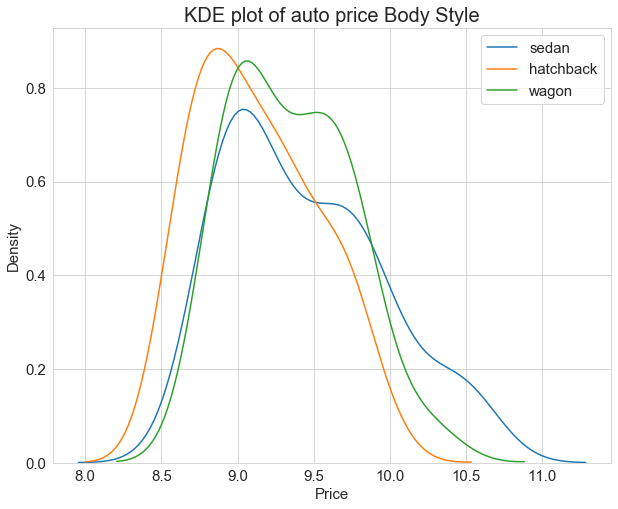

In [30]:
kde_plots(sedan,hatchback,wagon,"sedan","hatchback","wagon","Body Style")

The difference is seen between the `hatchback` vs `sedan` (statistically significant difference). Looking at the distribution plot is hard to tell any difference, but if there was any difference it would be between the blue curve and the orange (which is what we have).

### Boostrap

In [31]:
n_replicas = 1000

sedan1 = auto[auto['body-style'] == 'sedan']
hatchback1 = auto[auto['body-style'] == 'hatchback']
wagon1 = auto[auto['body-style'] == 'wagon']

sedan_bootstrap_means = pd.Series([
    sedan1.sample(frac=1, replace=True).price_log.mean()
    for i in range(n_replicas)])

hatchback_bootstrap_means = pd.Series([
        hatchback1.sample(frac=1, replace=True).price_log.mean()
        for i in range(n_replicas)])

wagon_bootstrap_means = pd.Series([
        wagon1.sample(frac=1, replace=True).price_log.mean()
        for i in range(n_replicas)])

In [32]:
f_statistic, p_value = ss.f_oneway(sedan_bootstrap_means,hatchback_bootstrap_means,wagon_bootstrap_means)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 7292.566352227239
P-value = 0.0


Same as before the test is showing that there is a difference between some (of all) the distributions, and more details will be explored later.

In [33]:
#Creating a data frame with the boostraped mean and the categorical value (type of car body)
s = pd.Series('Sedan')
s = pd.concat([s]*len(sedan_bootstrap_means))

h = pd.Series('Hatchback')
h = pd.concat([h]*len(hatchback_bootstrap_means))

w = pd.Series('Wagon')
w = pd.concat([w]*len(wagon_bootstrap_means))

frames = [s, h, w]
result = pd.concat(frames).reset_index()
result = result.iloc[:,1]

frames2 = [sedan_bootstrap_means,hatchback_bootstrap_means,wagon_bootstrap_means]
result2 = pd.concat(frames2).reset_index()
result2 = result2.iloc[:,1]

car_df = pd.DataFrame({'body':result,
                     'price_log':result2})

#Tukey HSD Test
Tukey_HSD1 = pairwise_tukeyhsd(car_df["price_log"], car_df["body"])
print(Tukey_HSD1)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj  lower   upper  reject
------------------------------------------------------
Hatchback  Sedan   0.3114 0.001  0.3051  0.3177   True
Hatchback  Wagon    0.227 0.001  0.2208  0.2333   True
    Sedan  Wagon  -0.0844 0.001 -0.0906 -0.0781   True
------------------------------------------------------


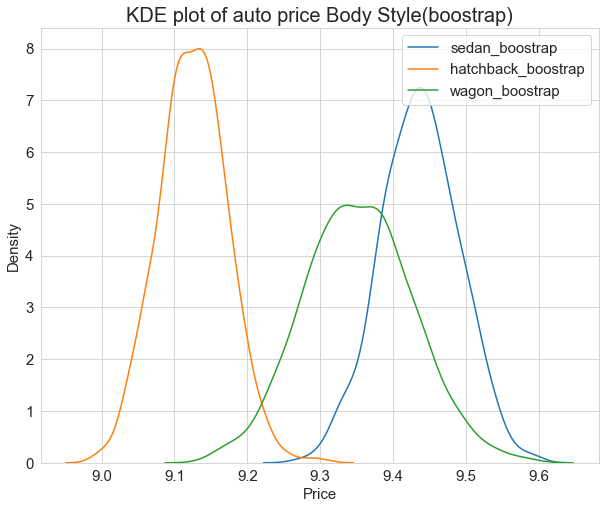

In [34]:
kde_plots(sedan_bootstrap_means,hatchback_bootstrap_means,wagon_bootstrap_means,"sedan_boostrap","hatchback_boostrap","wagon_boostrap","Body Style(boostrap)")

The test shows that there is a difference between all the 3 categories as seen in the table above (& plot).

### Bayes Model

In [35]:
pp_sedan = scipy.stats.norm.pdf(p, loc=sedan1.price_log.mean(), scale= np.std(sedan1.price_log))
pp_sedan = pp_sedan / pp_sedan.sum() # normalize

like_sedan = comp_like(p, sedan1.price_log)
post_sedan = posterior(pp_sedan, like_sedan)

##########################

pp_hatchback = scipy.stats.norm.pdf(p, loc=hatchback1.price_log.mean(), scale= np.std(hatchback1.price_log))
pp_hatchback = pp_hatchback / pp_hatchback.sum() # normalize

like_hatchback = comp_like(p, hatchback1.price_log)
post_hatchback = posterior(pp_hatchback, like_hatchback)

##########################

pp_wagon = scipy.stats.norm.pdf(p, loc=wagon1.price_log.mean(), scale= np.std(wagon1.price_log))
pp_wagon = pp_wagon / pp_wagon.sum() # normalize

like_wagon = comp_like(p, wagon1.price_log)
post_wagon = posterior(pp_wagon, like_wagon)

Mean = 9.439, Standard deviation = 0.510
Mean = 9.128, Standard deviation = 0.389
Mean = 9.351, Standard deviation = 0.372


The 0.950 credible interval is 9.336 to 9.541
The 0.950 credible interval is 9.036 to 9.218
The 0.950 credible interval is 9.207 to 9.493


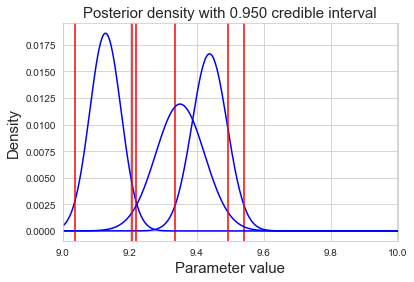

In [36]:
plot_ci(p, post_sedan, num_samples, lower_q=.025, upper_q=.975)
plot_ci(p, post_hatchback, num_samples, lower_q=.025, upper_q=.975)
plot_ci(p, post_wagon, num_samples, lower_q=.025, upper_q=.975)

**It is important to notice that the distribution curves seen in the Bayes model are pretty close to the ones seen after boostraping the mean.**

It is possible to see also that the credible intervals for 2 of the distributions overlap, but not entirely (Sedan & Wagon). I would say then that `hatchback` and `sedan` are therefore different.